In [1]:
loader = DataLoader(selected_datasets_per_qtype['exist'], batch_size=2, shuffle=False, num_workers=0, collate_fn=collate_samples_from_pixels)

NameError: name 'DataLoader' is not defined

In [2]:
b = next(iter(loader))

with torch.no_grad():
    model.eval()
    model.coord_tensor = None
    mid_res, _ = mid_getter(b['image'], b['question'])

NameError: name 'loader' is not defined

In [147]:
b['question'][0]

tensor([ 1,  2, 47, 21, 70, 31, 48, 17, 18, 26, 20, 17,  4, 41, 24, 12,  0])

In [119]:
%matplotlib inline

In [116]:
f_activations = torch.stack([mid_res[f'identity_fc{i}'] for i in range(1, 3)], dim=1)

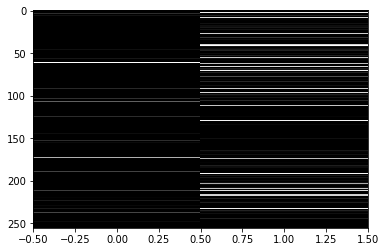

In [120]:
norm_activations = f_activations[0].t() * ((1 / f_activations[0].max(dim=1).values))
plt.imshow(norm_activations.detach().numpy(), aspect='auto', cmap='Greys_r')

In [144]:
g_activations = torch.stack([mid_res[f'identity_gc{i}'].view(-1, 64 * 64 * 256) for i in range(0, 4)], dim=1)

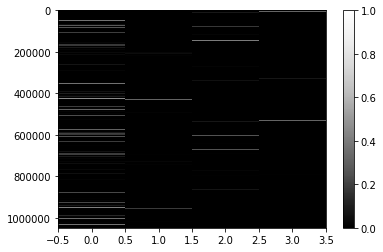

In [145]:
norm_activations_g = g_activations[0].t() * ((1 / g_activations[0].max(dim=1).values))
plt.imshow(norm_activations_g.detach().numpy(), aspect='auto', cmap='Greys_r')
plt.colorbar()

In [146]:
(g_activations[0] == 0).sum(dim=1)

tensor([ 782359,  943729,  982908, 1036209])

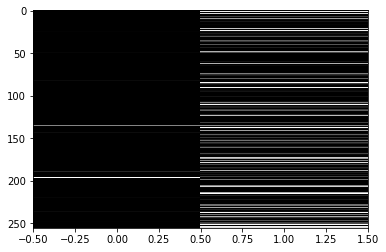

In [121]:
norm_activations2 = f_activations[1].t() * ((1 / f_activations[1].max(dim=1).values))
plt.imshow(norm_activations2.detach().numpy(), aspect='auto', cmap='Greys_r')

In [46]:
X_embedded = TSNE(n_components=2).fit_transform(torch.cat([all_res[qtype]['mha_gc1'] for qtype in qtypes]))

In [36]:
X_embedded

array([[ 153.93373 ,  129.25932 ],
       [ 207.70412 ,  -33.28526 ],
       [ -17.270176,  128.3473  ],
       [ -69.30714 ,  -34.757526],
       [  68.95953 ,   10.983522],
       [  69.73261 , -134.65114 ]], dtype=float32)

In [56]:
%matplotlib notebook

In [58]:
from matplotlib.cm import get_cmap

tab20 = get_cmap('tab20').colors

<IPython.core.display.Javascript object>


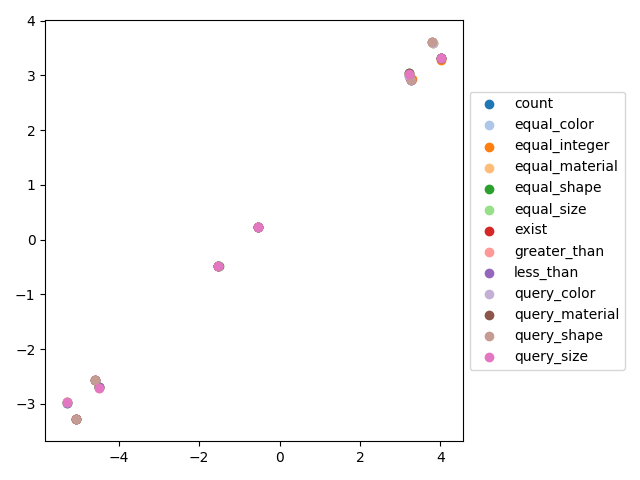

In [65]:
for i, qtype in enumerate(qtypes):
    plt.scatter(
        X_embedded[i * 6:(i + 1) * 6, 0], X_embedded[i * 6:(i + 1) * 6, 1],
        c=[tab20[i]],
        label=qtype,
    )

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [28]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
import os
import json
import pickle
import torch
import numpy as np
from matplotlib import colors
import matplotlib as mpl
import matplotlib.pyplot as plt

from attrdict import AttrDict

from model import RN
from model_vanilla import RN as RNVanilla
from viz_utils import init_selected_datasets, load_model, compute_mid_results, get_all_metrics, mha_keys, identity_keys, plot_masks_per_qtype, plot_masks_histograms, _get_mask_metrics


device = torch.device('cuda:0') if torch.cuda.is_available() else 'cpu'
print(torch.cuda.device_count())
device

1


device(type='cuda', index=0)

In [3]:
selected_ds_per_qtype, dictionaries = init_selected_datasets(
    '/mnt/nas2/GrimaRepo/datasets/CLEVR_v1.0',
    # '/Users/sebamenabar/Documents/datasets/CLEVR/CLEVR_v1.0/',
#     '/home/fcorencoret/RelationNetworks-CLEVR/questions/CLEVR_built_dictionaries.pkl',
    'viz/CLEVR_built_dictionaries.pkl',
    'viz/selected_idxs_per_qtype.json',
)

with open('config.json', 'r') as f:
    hyp = json.load(f)['hyperparams']['original-fp']
    
qtypes = list(selected_ds_per_qtype.keys())

args = AttrDict()
args.qdict_size = len(dictionaries[0])
args.adict_size = len(dictionaries[1])

==> using cached questions: questions/CLEVR_val_questions.pkl


In [4]:
hyp

{'state_description': False,
 'g_layers': [256, 256, 256, 256],
 'question_injection_position': 0,
 'f_fc1': 256,
 'f_fc2': 256,
 'dropout': 0.5,
 'lstm_hidden': 256,
 'lstm_word_emb': 32,
 'rl_in_size': 52}

In [5]:
# hyp['lstm_hidden'] = 128
model = load_model(
    RN(args, hyp),
    '/home/fcorencoret/RelationNetworks-CLEVR/Only_attn_norm_L1/best_weights.pth',
#     '/home/rmanterola/repos/dynamic-rn/nRelu_Norm_L1_0.1_sb_0.5/best_weights.pth',
#     data_parallel=False,
    device_ids=[device],
)

Supposing original DeepMind model


In [5]:
model_name = 'Norm L1 0.1 SB 0.5'
model_folder = 'Norm_L1_sb_0.5'
if not os.path.exists(f'images/{model_folder}'):
    os.makedirs(f'images/{model_folder}')

In [43]:
res = compute_mid_results(
    model,
    selected_ds_per_qtype,
    bsz=128,
    device=device,
    samples_per_qtype=128,
    with_identity=True,
    # with_attention=False,
)

In [44]:
import collections
res_mask = collections.OrderedDict({k : v for k,v in res.items() if ('question' not in k and 'answer' not in k)})
res_questions = collections.OrderedDict({k.replace('_question', '') : v for k,v in res.items() if 'question' in k})
res_answers = collections.OrderedDict({k.replace('_answer', '') : v for k,v in res.items() if 'answer' in k})

In [45]:
metrics = get_all_metrics(
    res_mask,
    # mha_names=[],
)

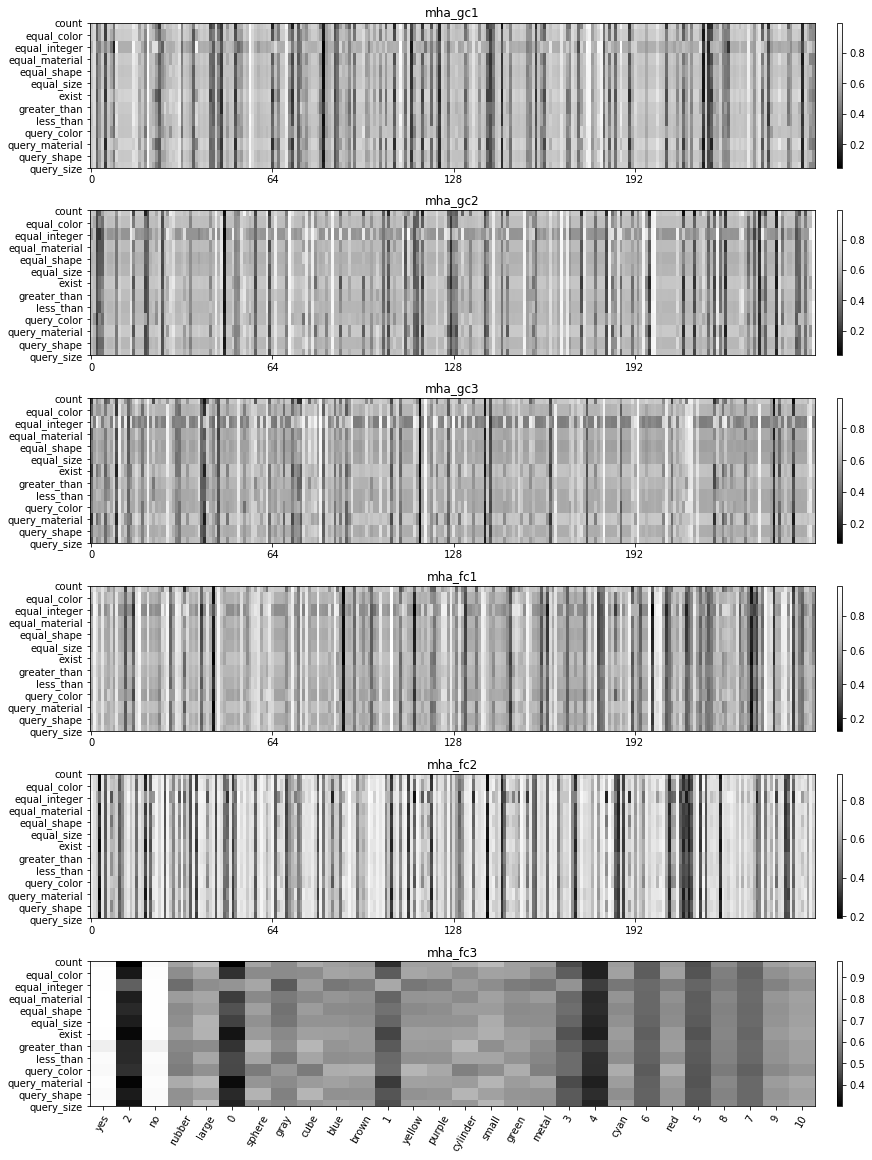

In [46]:
fig, axes = plot_masks_per_qtype(res_mask, adict=dictionaries[1])
# fig.suptitle(f'{model_name} - Mean Mask per Question')
fig.show()
# fig.savefig(f'images/{model_folder}/mean_mask_per_question.jpg', dpi=200)

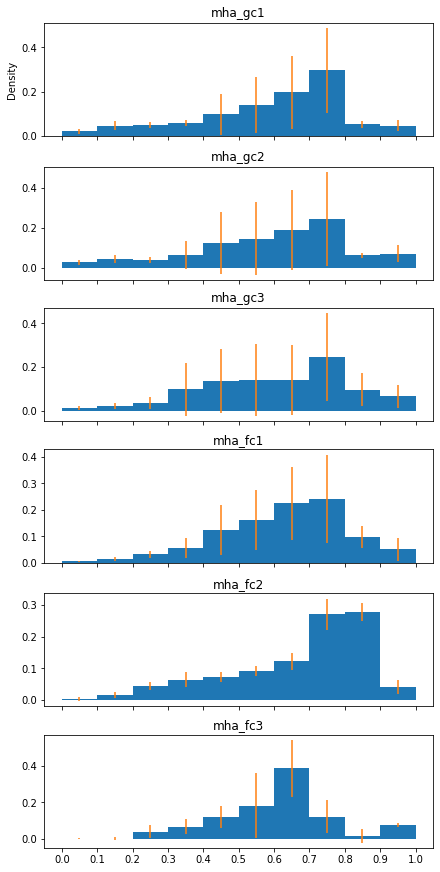

In [47]:
fig, axes = plot_masks_histograms(metrics['agg_metrics'])
# fig.suptitle(f'{model_name} - Agg Masks Distribution')
fig.suptitle(f'Agg Masks Distribution')
axes[-1].set_xlabel('Mask value')
fig.show()
# fig.savefig(f'images/{model_folder}/agg_masks_distribution.jpg', dpi=200)

In [48]:
ssz = metrics['agg_metrics'][identity_keys[0]]['sparsity'].size(0)

sparsity_histograms = {
    identity_name: _get_mask_metrics(metrics['agg_metrics'][identity_name]['sparsity'].view(ssz, -1))
    for identity_name in identity_keys
}

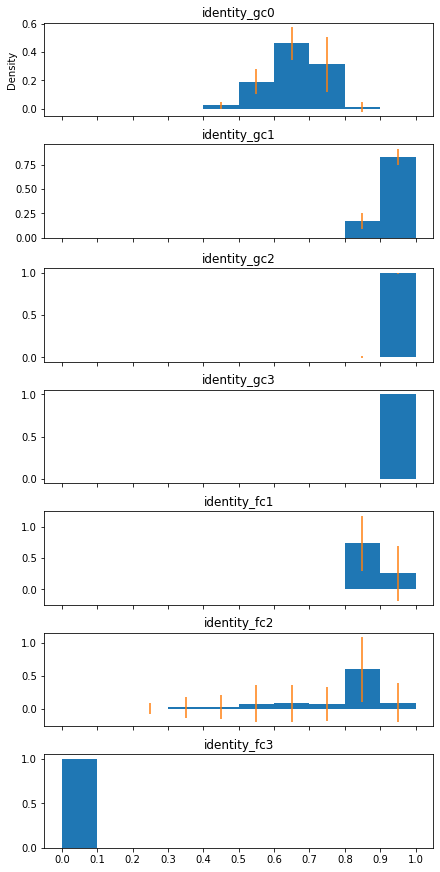

In [49]:
fig, axes = plot_masks_histograms(sparsity_histograms, keys=identity_keys)
# fig.suptitle(f'{model_name} - Agg Activation Sparsity')
fig.suptitle(f'Agg Activation Sparsity')
fig.show()
# fig.savefig(f'images/{model_folder}/agg_activation_sparsity.jpg', dpi=200)

In [99]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances_argmin_min
import matplotlib.pyplot as plt
import collections

In [51]:
q_dict = {v : k for k,v in dictionaries[0].items()}
a_dict = {v : k for k,v in dictionaries[1].items()}

In [52]:
masks = collections.OrderedDict({'mha_gc1' : [], 'mha_gc2':[], 'mha_gc3':[], 'mha_fc1':[], 'mha_fc2':[], 'mha_fc3':[]})
questions, answers, category = [], [], []
for key, value in res_mask.items():
    masks['mha_gc1'].append(value['mha_gc1'])
    masks['mha_gc2'].append(value['mha_gc2'])
    masks['mha_gc3'].append(value['mha_gc3'])
    masks['mha_fc1'].append(value['mha_fc1'])
    masks['mha_fc2'].append(value['mha_fc2'])
    masks['mha_fc3'].append(value['mha_fc3'])
    for b in res_questions[key]:
        for q in b: 
            string = ''
            for word in q: 
                if word.item() != 0: string += q_dict[word.item()] + ' ' 
                else: break
            questions.append([string])
            category.append(key)
        
    for b in res_answers[key]:
        for q in b: answers.append(a_dict[q.item()])
            
masks['mha_gc1'] = np.stack(masks['mha_gc1']).reshape(-1, 256)
masks['mha_gc2'] = np.stack(masks['mha_gc2']).reshape(-1, 256)
masks['mha_gc3'] = np.stack(masks['mha_gc3']).reshape(-1, 256)
masks['mha_fc1'] = np.stack(masks['mha_fc1']).reshape(-1, 256)
masks['mha_fc2'] = np.stack(masks['mha_fc2']).reshape(-1, 256)
masks['mha_fc3'] = np.stack(masks['mha_fc3']).reshape(-1, 28)


In [53]:
def scatter(plt, key, value):
    x_embedded = TSNE(n_components=2, perplexity=50).fit_transform(value)
    plt.scatter(x_embedded[:, 0], x_embedded[:, 1], c=clusters)
    plt.title.set_text(key)

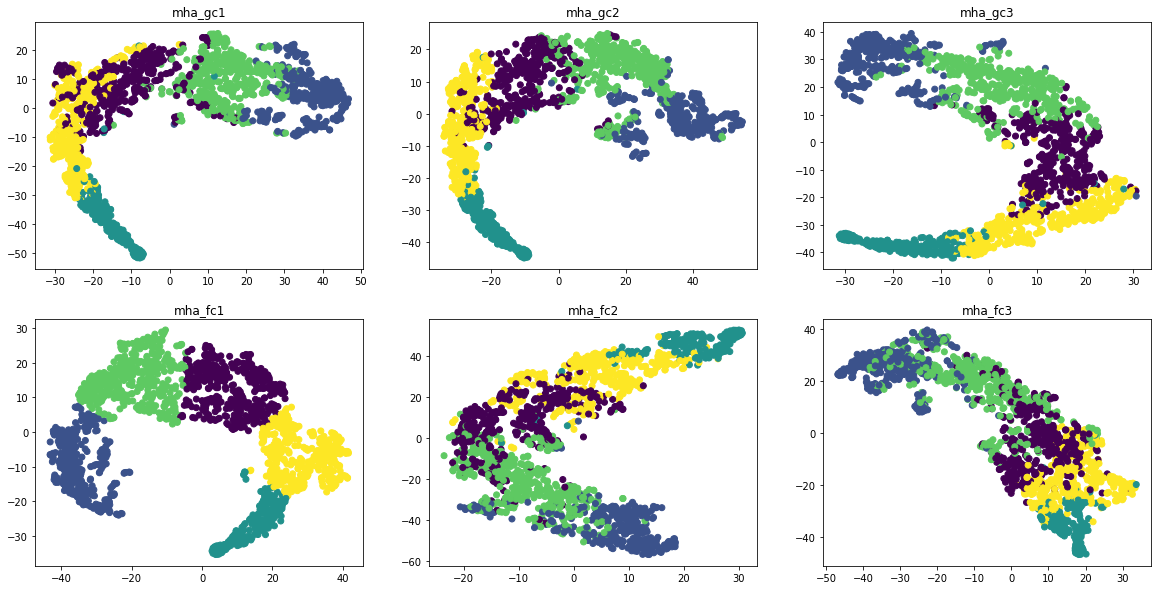

In [57]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
row, col = 0,0
for key,value in masks.items():
    scatter(ax[row][col], key, value)
    col += 1
    if col > 2:
        col = 0
        row+=1

In [54]:
x_embedded = TSNE(n_components=2, perplexity=50).fit_transform(masks['mha_fc1'])

In [106]:
n_clusters=5
km = KMeans(n_clusters=n_clusters, random_state=0).fit(x_embedded)
clusters = km.predict(x_embedded)
# clusters = DBSCAN(eps=5, min_samples=3).fit_predict(x_embedded)
clusters

array([4, 4, 4, ..., 3, 4, 3], dtype=int32)

In [107]:
closest, _ = pairwise_distances_argmin_min(km.cluster_centers_, x_embedded)
closest

array([1474,  280,  247, 1608, 1578])

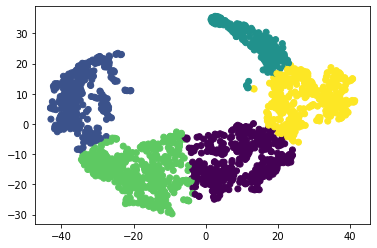

In [108]:
# x_embedded = TSNE(n_components=2, perplexity=50).fit_transform(masks['mha_fc3'])
plt.scatter(x_embedded[:, 0], x_embedded[:, 1], c=clusters)

In [114]:
for c in range(n_clusters):
    print(f'Cluster {c + 1}: {questions[closest[c]]}')

Cluster 1: ['what is the shape of the small thing that is the same color as the big metallic cube ? ']
Cluster 2: ['are there an equal number of small blue things that are in front of the large blue cube and gray matte things that are right of the blue shiny block ? ']
Cluster 3: ['do the large cube and the matte object have the same color ? ']
Cluster 4: ['there is a cube that is to the right of the matte cube behind the yellow rubber object ; what is its size ? ']
Cluster 5: ['the cylinder that is the same color as the small shiny cube is what size ? ']


In [58]:
a = list(zip(questions, answers, clusters, category))

In [59]:
quest_clusters = []
for i in range(8):
    quest_clusters.append([x for x in a if x[2]==i])


In [94]:
unique, counts = np.unique(np.array([z[3] for z in quest_clusters[0]]), return_counts=True)

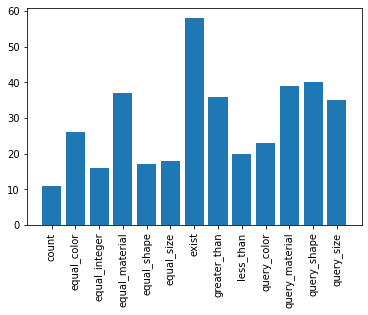

In [95]:
plt.bar(unique, counts)
plt.xticks(rotation='vertical')
plt.show()

In [61]:
quest_clusters[0]

[(['how many big balls are both behind the brown sphere and to the left of the big yellow metallic object ? '],
  '1',
  0,
  'count'),
 (['what number of cylinders are both right of the blue rubber block and behind the small cylinder ? '],
  '1',
  0,
  'count'),
 (['what number of objects are tiny metallic things in front of the brown shiny ball or green things ? '],
  '2',
  0,
  'count'),
 (['what number of objects are cylinders in front of the tiny blue rubber sphere or yellow rubber blocks ? '],
  '2',
  0,
  'count'),
 (['what number of objects are in front of the yellow matte sphere and on the left side of the metal thing ? '],
  '2',
  0,
  'count'),
 (['how many things are tiny things that are in front of the cyan thing or small gray cylinders ? '],
  '1',
  0,
  'count'),
 (['how many gray matte things are to the left of the yellow cube and right of the yellow shiny block ? '],
  '0',
  0,
  'count'),
 (['how many green spheres are to the left of the big object on the right 

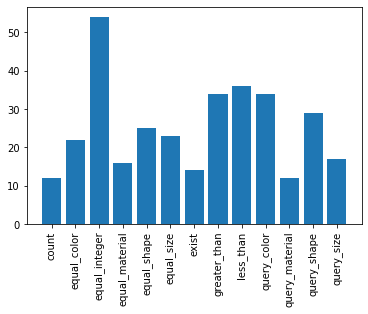

In [96]:
unique, counts = np.unique(np.array([z[3] for z in quest_clusters[1]]), return_counts=True)
plt.bar(unique, counts)
plt.xticks(rotation='vertical')
plt.show()

In [63]:
quest_clusters[1]

[(['there is a big metallic object in front of the sphere to the right of the small purple rubber thing ; what number of things are behind it ? '],
  '2',
  1,
  'count'),
 (['there is a metal cylinder that is right of the large yellow object that is behind the small cyan sphere ; how many small rubber objects are on the right side of it ? '],
  '2',
  1,
  'count'),
 (['there is a brown block that is behind the sphere on the right side of the large yellow matte object ; what number of gray objects are in front of it ? '],
  '1',
  1,
  'count'),
 (['how many large purple blocks are to the right of the tiny gray block that is left of the small gray cube to the right of the big purple shiny object ? '],
  '1',
  1,
  'count'),
 (['how many large objects are both in front of the green shiny cylinder and on the right side of the large green rubber object ? '],
  '3',
  1,
  'count'),
 (['how many objects are small things that are on the right side of the tiny purple metallic cylinder or t

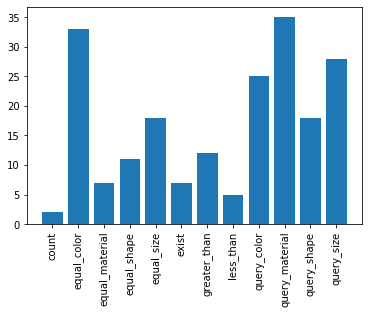

In [97]:
unique, counts = np.unique(np.array([z[3] for z in quest_clusters[2]]), return_counts=True)
plt.bar(unique, counts)
plt.xticks(rotation='vertical')
plt.show()

In [65]:
quest_clusters[2]

[(['how many purple matte blocks are there ? '], '1', 2, 'count'),
 (['what number of small rubber balls are there ? '], '1', 2, 'count'),
 (['is the color of the large shiny object the same as the small ball ? '],
  'no',
  2,
  'equal_color'),
 (['does the large cylinder have the same color as the tiny block ? '],
  'no',
  2,
  'equal_color'),
 (['do the matte cylinder and the small block have the same color ? '],
  'no',
  2,
  'equal_color'),
 (['is the small metal cylinder the same color as the matte cylinder ? '],
  'yes',
  2,
  'equal_color'),
 (['is the small matte cylinder the same color as the large matte block ? '],
  'no',
  2,
  'equal_color'),
 (['is the color of the big metallic cylinder the same as the metallic sphere ? '],
  'yes',
  2,
  'equal_color'),
 (['is the metallic block the same color as the metal ball ? '],
  'no',
  2,
  'equal_color'),
 (['does the large matte sphere have the same color as the metal cylinder ? '],
  'yes',
  2,
  'equal_color'),
 (['is t

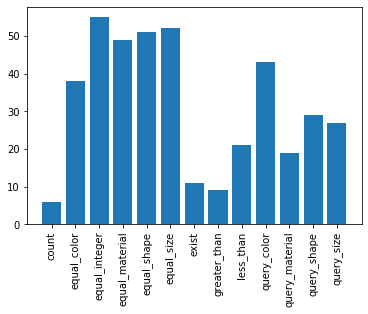

In [115]:
unique, counts = np.unique(np.array([z[3] for z in quest_clusters[3]]), return_counts=True)
plt.bar(unique, counts)
plt.xticks(rotation='vertical')
plt.show()

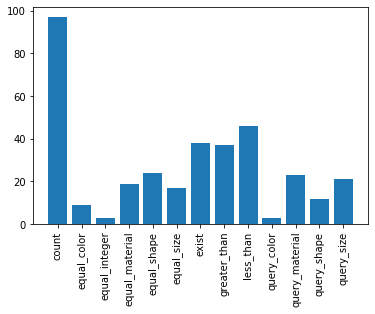

In [98]:
unique, counts = np.unique(np.array([z[3] for z in quest_clusters[4]]), return_counts=True)
plt.bar(unique, counts)
plt.xticks(rotation='vertical')
plt.show()